## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import date
today = date.today()

In [276]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [277]:
d1 = today.strftime("%m/%d/%y").replace(' 0', ' ')
if(d1[0] == '0'):
    d1 = d1[1:]
d1

'5/24/20'

### Function to get the number of confirmed cases as a Dataframe

In [278]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew
get_confirmed()

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817


### Function to get the number of deaths as a Dataframe

In [279]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new
get_deaths()

,Deaths
1/22/20,17
1/23/20,18
1/24/20,26
1/25/20,42
1/26/20,56
...,...
5/19/20,323285
5/20/20,328115
5/21/20,332924
5/22/20,338160


### Function to get the number of recoveries as a Dataframe

In [280]:
def get_recovered():
    rec_new = pd.read_csv(recovered_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new
get_recovered()

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643


### Scraper

In [281]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [282]:
numbers = get_newvals()
numbers

[5407414, 344023, 2247962]

## Forecasting Confirmed Cases

In [283]:
df = get_confirmed()
df.tail()

,Infected
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


In [284]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [285]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [286]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 123ms/step - loss: 10059639823808.0664
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 9924626880994.8438
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 9781490160247.3398
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 9711703800299.8340
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 9600189449751.9336
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 9510657030214.9414
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 9442730645417.1895
Epoch 8/100
7/7 [==============================] - 0s 17ms/step - loss: 9370938707727.4707
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 9285223793618.9082
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 9237726797136.2637
Epoch 11/100
7/7 [==============================] - 0s 18ms/step - loss: 9174282688010.64

7/7 [==============================] - 0s 14ms/step - loss: 7589561789177.5869
Epoch 91/100
7/7 [==============================] - 0s 7ms/step - loss: 7589561788552.9922
Epoch 92/100
7/7 [==============================] - 0s 22ms/step - loss: 7589561787014.8096
Epoch 93/100
7/7 [==============================] - 0s 21ms/step - loss: 7589561787005.4873
Epoch 94/100
7/7 [==============================] - 0s 20ms/step - loss: 7589561767801.5205
Epoch 95/100
7/7 [==============================] - 0s 10ms/step - loss: 7589561767559.1406
Epoch 96/100
7/7 [==============================] - 0s 10ms/step - loss: 7589561766943.8682
Epoch 97/100
7/7 [==============================] - 0s 10ms/step - loss: 7589561766757.4219
Epoch 98/100
7/7 [==============================] - 0s 22ms/step - loss: 7589561766496.3965
Epoch 99/100
7/7 [==============================] - 0s 17ms/step - loss: 7589561766477.7520
Epoch 100/100
7/7 [==============================] - 0s 22ms/step - loss: 7589561766300.6279


In [287]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [288]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [289]:
forecast

5407414

In [290]:
df.tail()

,Infected
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


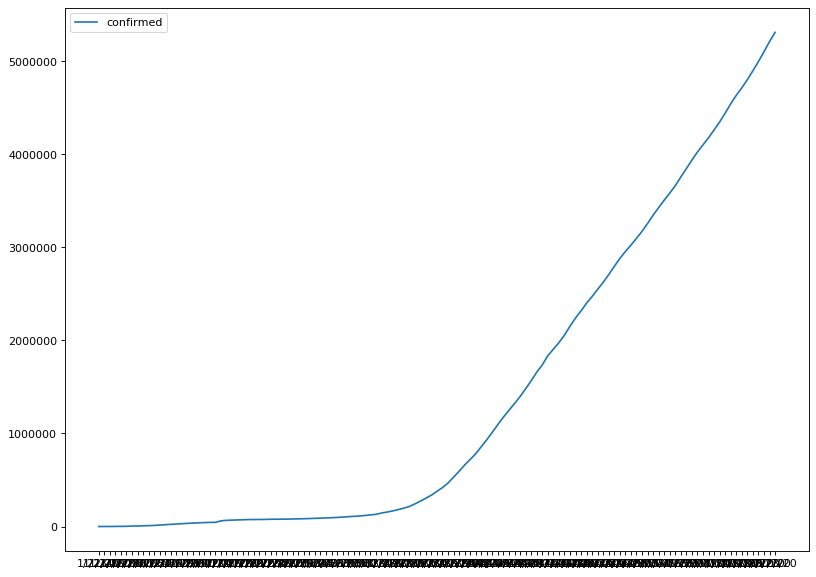

In [291]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df, label='confirmed')
plt.legend(loc="upper left")

In [292]:
df_temp = df
df_temp.loc[d1] = forecast
df_temp

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


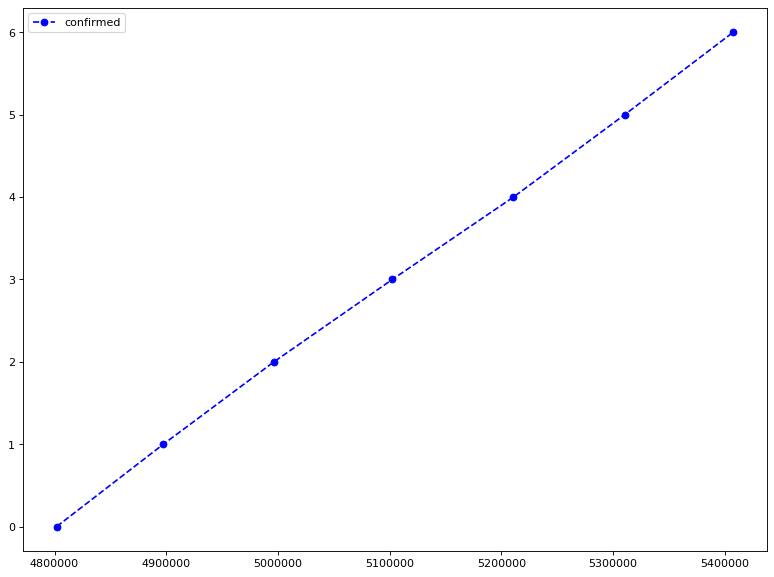

In [293]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp[-7:], range(7), linestyle='--', marker='o', color='b', label='confirmed')
plt.legend(loc="upper left")

## Forecasting Recoveries

In [294]:
df_rec = get_recovered()
df_rec.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


In [295]:
close_data_rec = df_rec['Recovered'].values
close_data_rec = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_rec))

close_train_rec = close_data_rec[:split]
close_test_rec = close_data_rec[split:]

cclose_rec = close_data_rec

In [296]:
look_back = 2

train_generator_rec = TimeseriesGenerator(cclose_rec, cclose_rec, length=look_back, batch_size=20)     
test_generator_rec = TimeseriesGenerator(close_test_rec, close_test_rec, length=look_back, batch_size=1)

In [297]:
prediction_rec = model.predict_generator(test_generator_rec)

cclose_rec = cclose_rec.reshape((-1))
close_train_rec = close_train_rec.reshape((-1))
close_test_rec = close_test_rec.reshape((-1))
prediction_rec = prediction_rec.reshape((-1))

In [298]:
close_data_rec = close_data_rec.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_rec[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_rec = predict(num_prediction, model)
forecast_rec = numbers[2]

In [299]:
forecast_rec

2247962

In [300]:
df_rec.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


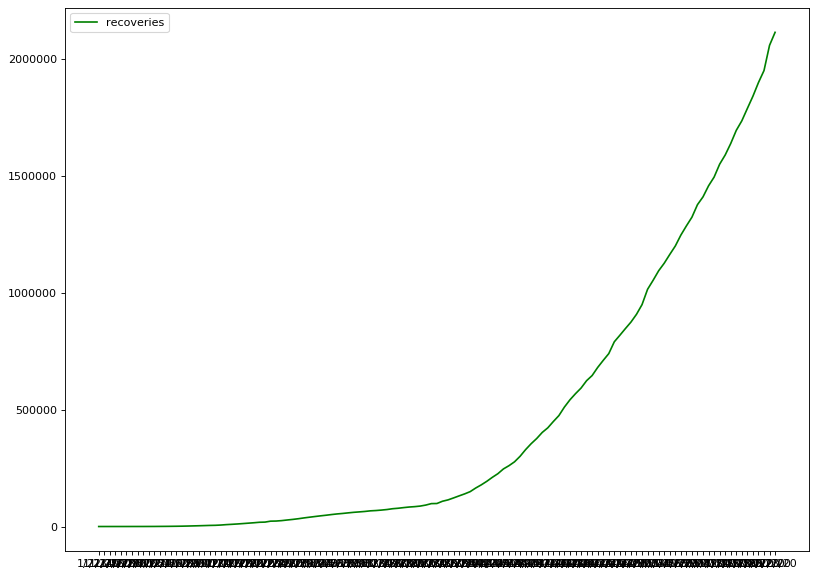

In [301]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_rec, color='g', label='recoveries')
plt.legend(loc="upper left")

In [302]:
df_temp_rec = df_rec
df_temp_rec.loc[d1] = forecast_rec
df_temp_rec

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


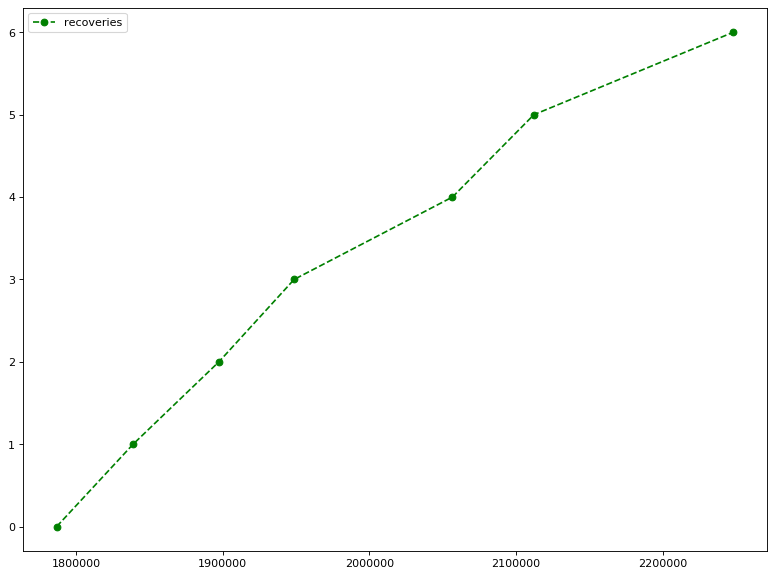

In [303]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_rec[-7:], range(7), linestyle='--', marker='o', color='g', label='recoveries')
plt.legend(loc="upper left")

## Forecasting Deaths

In [304]:
df_dea = get_deaths()
df_dea.tail()

,Deaths
5/19/20,323285
5/20/20,328115
5/21/20,332924
5/22/20,338160
5/23/20,342097


In [305]:
close_data_dea = df_dea['Deaths'].values
close_data_dea = close_data_dea.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_dea))

close_train_dea = close_data_dea[:split]
close_test_dea = close_data_dea[split:]

cclose_dea = close_data_dea

In [306]:
look_back = 2

train_generator_dea = TimeseriesGenerator(cclose_dea, cclose_dea, length=look_back, batch_size=20)     
test_generator_dea = TimeseriesGenerator(close_test_dea, close_test_dea, length=look_back, batch_size=1)

In [307]:
prediction_dea = model.predict_generator(test_generator_dea)

cclose_dea = cclose_dea.reshape((-1))
close_train_dea = close_train_dea.reshape((-1))
close_test_dea = close_test_dea.reshape((-1))
prediction_dea = prediction_dea.reshape((-1))

In [308]:
close_data_dea = close_data_dea.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_dea[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_dea = predict(num_prediction, model)
forecast_dea = numbers[1]

In [309]:
forecast_dea

344023

In [310]:
df_dea.tail()

,Deaths
5/19/20,323285
5/20/20,328115
5/21/20,332924
5/22/20,338160
5/23/20,342097


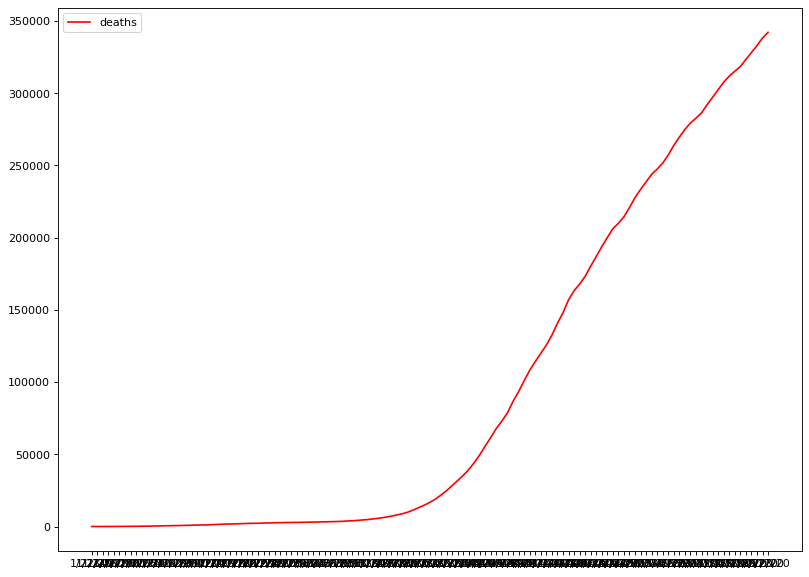

In [311]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_dea, color='r', label='deaths')
plt.legend(loc="upper left")

In [312]:
df_temp_dea = df_dea
df_temp_dea.loc[d1] = forecast_dea
df_temp_dea

,Deaths
1/22/20,17
1/23/20,18
1/24/20,26
1/25/20,42
1/26/20,56
...,...
5/20/20,328115
5/21/20,332924
5/22/20,338160
5/23/20,342097


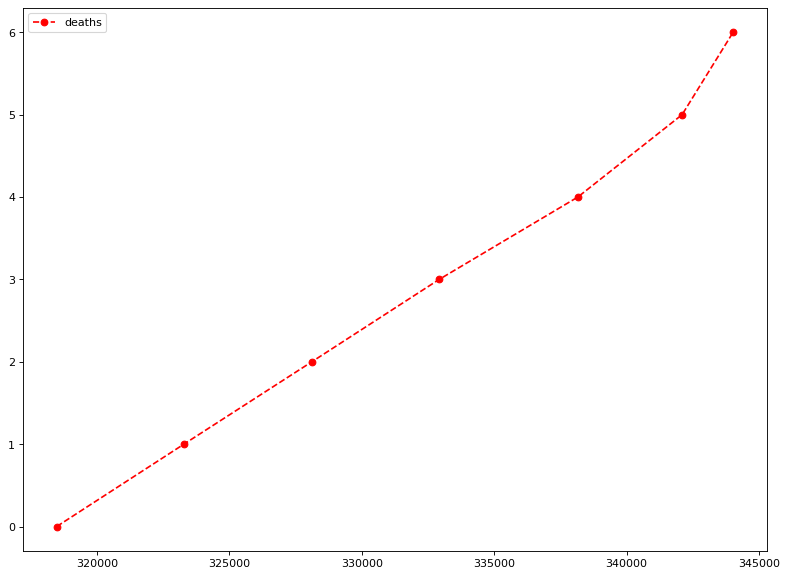

In [313]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_dea[-7:], range(7), linestyle='--', marker='o', color='r', label='deaths')
plt.legend(loc="upper left")